In [68]:
import numpy as np
import neuroboros as nb
from scipy.stats import zscore,pearsonr
from scipy.spatial.distance import pdist, cdist, squareform
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from hyperalignment.procrustes import procrustes
from hyperalignment.ridge import ridge
from hyperalignment.local_template import compute_template
from hyperalignment.searchlight import searchlight_procrustes, searchlight_ridge
import pandas as pd
import seaborn as sns

## Load data
Data is preprocessed on the fly to regress out motion etc. in the get_data() function

In [93]:
dset = nb.Life()
sids = dset.subjects
print(sids)

['rid000001', 'rid000005', 'rid000006', 'rid000009', 'rid000012', 'rid000014', 'rid000017', 'rid000019', 'rid000020', 'rid000024', 'rid000027', 'rid000031', 'rid000032', 'rid000033', 'rid000034', 'rid000036', 'rid000037', 'rid000038', 'rid000041']


In [ ]:
training_runs = [1,2]
test_runs = [3,4]
lr = 'lr' # left + right hemisphere, 'l' for left hemisphere, 'r' for right hemisphere
ts1_train = dset.get_data(sids[0], 'life', [1, 2], lr)
ts1_test = dset.get_data(sids[0], 'life', [3, 4], lr)

ts2_train = dset.get_data(sids[1], 'life', [1, 2], lr)
ts2_test = dset.get_data(sids[1], 'life', [3, 4], lr)

In [96]:
print(ts1_train.shape, ts2_train.shape)

(704, 19341) (704, 19341)


## Load Searchlight
You can think of searchlights as region of interests (ROIs) but in the Haxby lab we use overlapping searchlights centered at each vertex with a fixed radius (up to 20 mm, inter-vertex distance calculated as average across 1000 subjects used in the creation of onavg template). We can also use existing parcellation like Gordon, Schaefer, Glasser, Shen etc. to parcellate the brain and align each ROI. If we want to align subcortical areas we'd probably use the Freesurfer ROIs. 

In [ ]:
radius = 10
sls, dists = nb.sls(lr, radius, return_dists=True)
print(len(sls),sls[0].shape,sls[1].shape) 
# for onavg-ico32 we have 19341 vertices after medial wall masking (9675 left and 9666 right), searchlight 0 has 25 vertices, and 1 has 28 vertices

19341 (119,) (123,)


## Hyperalignment
Basically finding the transformation to go from one subject's response to another subject's response.
Different ways of finding that transformation function including "procrustes"[1] and "warp"[2]. We use warp here, which is basically ridge regression. And we could use response, connectivity or both to find the transformation. <br>
[1] [Guntupalli et al. 2016 Cerebral Cortex](https://academic.oup.com/cercor/article/26/6/2919/1754308) <br>
[2] [Feilong et al. 2023 Imaging Neuroscience](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00032/117980)


### 1) Response hyperalignment

In [ ]:
wRHA = searchlight_ridge(ts1_train, ts2_train, sls, dists, radius) 

### 2) Connectivity hyperalignment
We need to first calculate the connectivity, instead of the vertex-by-vertex connectivity in all ico32 vertices, we are downsampling the targets to ico8 so that it's less computationally expensive.

In [73]:
downsample_xfm = nb.mapping(lr, 'onavg-ico32', 'onavg-ico8', mask=True)

In [74]:
conn1_train = 1 - cdist((ts1_train@downsample_xfm).T, ts1_train.T, 'correlation')
conn2_train = 1 - cdist((ts2_train@downsample_xfm).T, ts2_train.T, 'correlation')
print(conn1_train.shape,conn2_train.shape)

(1210, 19341) (1210, 19341)


In [75]:
wCHA = searchlight_ridge(conn1_train,conn2_train, sls, dists, radius) 

### 3) Hybrid hyperalignment
We can use both response and connectivity too.

In [76]:
wHHA = searchlight_ridge(np.concatenate((ts1_train,conn1_train),axis=0),np.concatenate((ts2_train,conn2_train),axis=0), sls, dists, radius) 

## Evaluation of hyperalignment performance

In [77]:
# Calculate the predicted responses
pred_ts1_test_RHA = ts1_test @ wRHA
pred_ts1_test_CHA = ts1_test @ wCHA
pred_ts1_test_HHA = ts1_test @ wHHA

# Calculate the predicted connectivity
conn1_test = 1 - cdist((ts1_test@downsample_xfm).T, ts1_test.T, 'correlation')
conn2_test = 1 - cdist((ts2_test@downsample_xfm).T, ts2_test.T, 'correlation')
pred_conn1_test_RHA = conn1_test @ wRHA
pred_conn1_test_CHA = conn1_test @ wCHA
pred_conn1_test_HHA = conn1_test @ wHHA

In [78]:
# Calculate inter-subject correlation in responses
isc_AA = np.array([pearsonr(ts1_test[:,i], ts2_test[:,i])[0] for i in range(ts1_test.shape[1])])
isc_RHA = np.array([pearsonr(pred_ts1_test_RHA[:,i], ts2_test[:,i])[0] for i in range(pred_ts1_test_RHA.shape[1])])
isc_CHA = np.array([pearsonr(pred_ts1_test_CHA[:,i], ts2_test[:,i])[0] for i in range(pred_ts1_test_CHA.shape[1])])
isc_HHA = np.array([pearsonr(pred_ts1_test_HHA[:,i], ts2_test[:,i])[0] for i in range(pred_ts1_test_HHA.shape[1])])
print(isc_AA.shape,isc_RHA.shape, isc_CHA.shape, isc_HHA.shape)

# Calculate inter-subject correlation in connectivity
isc_conn_AA = np.array([pearsonr(conn1_test[:,i], conn2_test[:,i])[0] for i in range(conn1_test.shape[1])])
isc_conn_RHA = np.array([pearsonr(pred_conn1_test_RHA[:,i], conn2_test[:,i])[0] for i in range(pred_conn1_test_RHA.shape[1])])
isc_conn_CHA = np.array([pearsonr(pred_conn1_test_CHA[:,i], conn2_test[:,i])[0] for i in range(pred_conn1_test_CHA.shape[1])])
isc_conn_HHA = np.array([pearsonr(pred_conn1_test_HHA[:,i], conn2_test[:,i])[0] for i in range(pred_conn1_test_HHA.shape[1])])
print(isc_conn_AA.shape, isc_conn_RHA.shape, isc_conn_CHA.shape, isc_conn_HHA.shape)

(19341,) (19341,) (19341,) (19341,)
(19341,) (19341,) (19341,) (19341,)


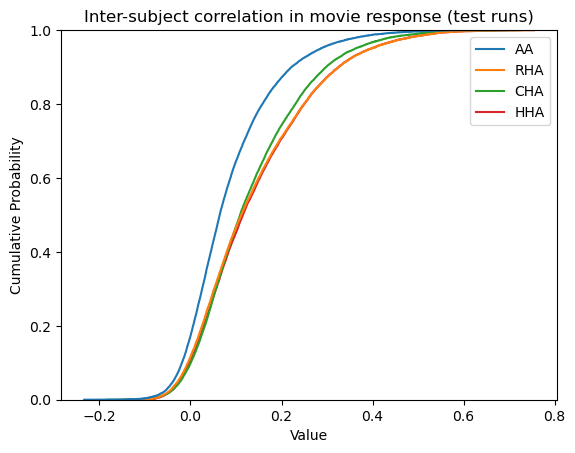

In [79]:
df = pd.DataFrame(np.column_stack((isc_AA, isc_RHA, isc_CHA, isc_HHA)),
                 columns=["AA", "RHA", "CHA", "HHA"])  
# Plot all ECDFs with automatic legend
sns.ecdfplot(data=df)
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Inter-subject correlation in movie response (test runs)")
plt.show()

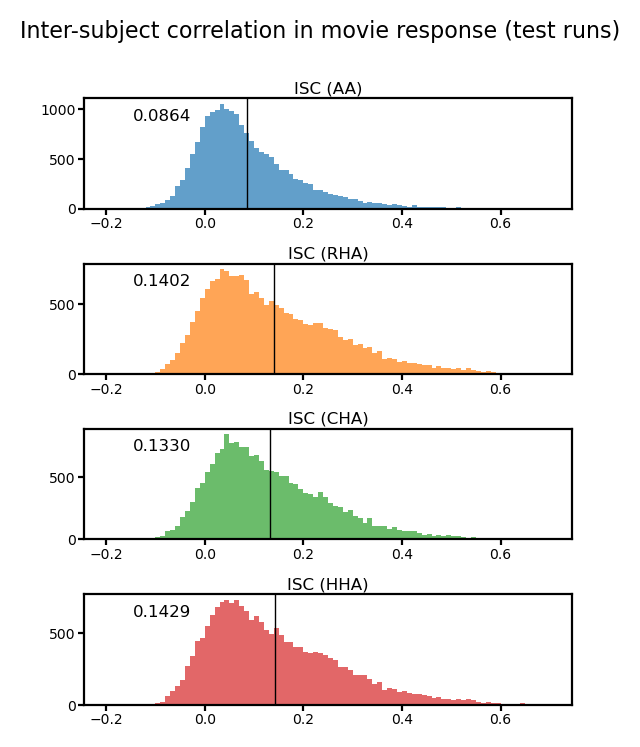

In [80]:
fig, axs = plt.subplots(4, 1, figsize=(8/2.54, 10/2.54), dpi=200)

# Get Seaborn's default blue color (same as ecdfplot)
current_palette = sns.color_palette()

for i, (ax, isc) in enumerate(zip(axs, df.values.T)):
    # Histogram with Seaborn's default ECDF color
    ax.hist(isc, bins=np.linspace(-0.2, 0.7, 91), color=current_palette[i], alpha=0.7)
    
    # Mean line and annotations
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    
    # Title and mean value annotation
    title = ['ISC (AA)', 'ISC (RHA)', 'ISC (CHA)', 'ISC (HHA)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)

# Adjust layout and add overall title
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Inter-subject correlation in movie response (test runs)", fontsize=8)  # Reduced fontsize for tight layout
plt.show()


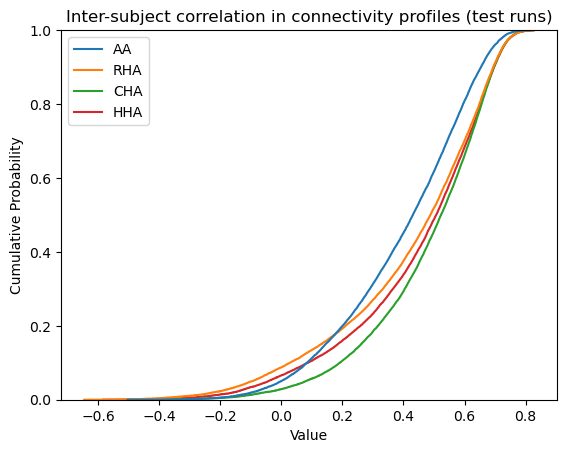

In [81]:
df2 = pd.DataFrame(np.column_stack((isc_conn_AA, isc_conn_RHA, isc_conn_CHA, isc_conn_HHA)),
                 columns=["AA", "RHA", "CHA", "HHA"])  
# Plot all ECDFs with automatic legend
sns.ecdfplot(data=df2)
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Inter-subject correlation in connectivity profiles (test runs)")
plt.show()

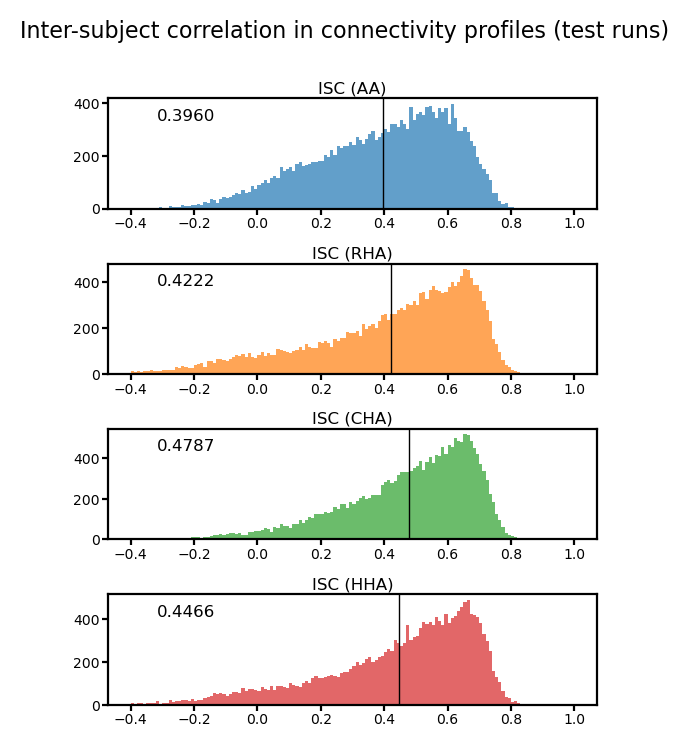

In [89]:
fig, axs = plt.subplots(4, 1, figsize=(8/2.54, 10/2.54), dpi=200)

# Get Seaborn's default blue color (same as ecdfplot)
current_palette = sns.color_palette()

for i, (ax, isc) in enumerate(zip(axs, df2.values.T)):
    # Histogram with Seaborn's default ECDF color
    ax.hist(isc, bins=np.linspace(-0.4, 1.0, 141), color=current_palette[i], alpha=0.7)
    
    # Mean line and annotations
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    
    # Title and mean value annotation
    title = ['ISC (AA)', 'ISC (RHA)', 'ISC (CHA)', 'ISC (HHA)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)

# Adjust layout and add overall title
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Inter-subject correlation in connectivity profiles (test runs)", fontsize=8)  # Reduced fontsize for tight layout
plt.show()


## Does using Z-scored response or connectivity improves intersubject alignment?

In [88]:
wRHA_zscore = searchlight_ridge(
    zscore(ts1_train, axis=0), zscore(ts2_train, axis=0), sls, dists, radius)
wCHA_zscore = searchlight_ridge(
    zscore(conn1_train, axis=0), zscore(conn2_train, axis=0), sls, dists, radius)
wHHA_zscore = searchlight_ridge(
    np.concatenate((zscore(ts1_train, axis=0),zscore(conn1_train, axis=0)), axis=0), np.concatenate((zscore(ts2_train, axis=0),zscore(conn2_train, axis=0)), axis=0), sls, dists, radius)

In [84]:
# Calculate the predicted responses
pred_ts1_test_RHA_zscore = ts1_test @ wRHA_zscore
pred_ts1_test_CHA_zscore = ts1_test @ wCHA_zscore
pred_ts1_test_HHA_zscore = ts1_test @ wHHA_zscore

# Calculate the predicted connectivity
pred_conn1_test_RHA_zscore = conn1_test @ wRHA_zscore
pred_conn1_test_CHA_zscore = conn1_test @ wCHA_zscore
pred_conn1_test_HHA_zscore = conn1_test @ wHHA_zscore

In [85]:
# Calculate inter-subject correlation in responses
isc_AA_zscore = np.array([pearsonr(zscore(ts1_test[:,i],axis=0), zscore(ts2_test[:,i],axis=0))[0] for i in range(conn1_test.shape[1])])
isc_RHA_zscore = np.array([pearsonr(pred_ts1_test_RHA_zscore[:,i], zscore(ts2_test[:,i],axis=0))[0] for i in range(pred_ts1_test_RHA.shape[1])])
isc_CHA_zscore = np.array([pearsonr(pred_ts1_test_CHA_zscore[:,i], zscore(ts2_test[:,i],axis=0))[0] for i in range(pred_ts1_test_CHA.shape[1])])
isc_HHA_zscore = np.array([pearsonr(pred_ts1_test_HHA_zscore[:,i], zscore(ts2_test[:,i],axis=0))[0] for i in range(pred_ts1_test_HHA.shape[1])])
# Calculate inter-subject correlation in connectivity
isc_conn_AA_zscore = np.array([pearsonr(zscore(conn1_test[:,i],axis=0), zscore(conn2_test[:,i],axis=0))[0] for i in range(conn1_test.shape[1])])
isc_conn_RHA_zscore = np.array([pearsonr(pred_conn1_test_RHA_zscore[:,i], zscore(conn2_test[:,i],axis=0))[0] for i in range(pred_conn1_test_RHA.shape[1])])
isc_conn_CHA_zscore = np.array([pearsonr(pred_conn1_test_CHA_zscore[:,i], zscore(conn2_test[:,i],axis=0))[0] for i in range(pred_conn1_test_CHA.shape[1])])
isc_conn_HHA_zscore = np.array([pearsonr(pred_conn1_test_HHA_zscore[:,i], zscore(conn2_test[:,i],axis=0))[0] for i in range(pred_conn1_test_HHA.shape[1])])


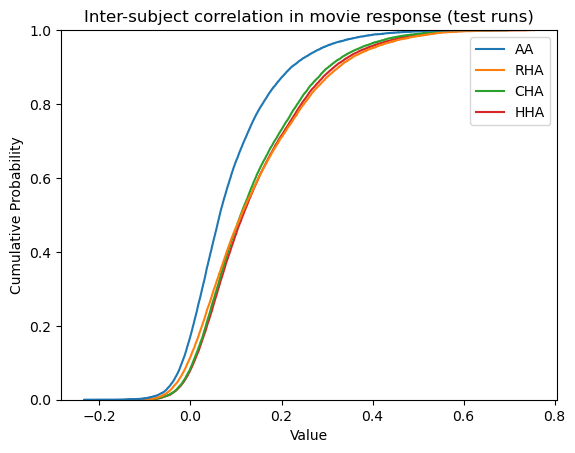

In [86]:
df = pd.DataFrame(np.column_stack((isc_AA_zscore, isc_RHA_zscore, isc_CHA_zscore, isc_HHA_zscore)),
                 columns=["AA", "RHA", "CHA", "HHA"])  
# Plot all ECDFs with automatic legend
sns.ecdfplot(data=df)
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Inter-subject correlation in movie response (test runs)")
plt.show()

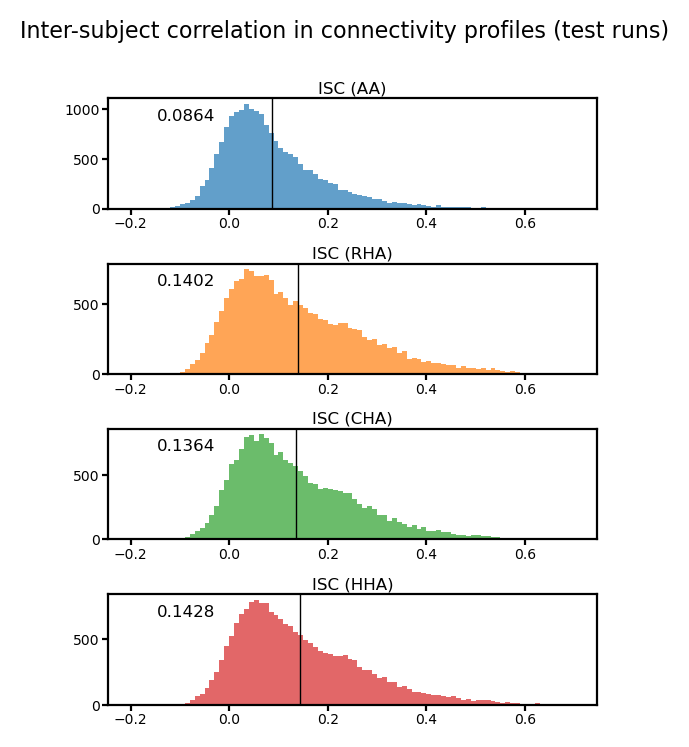

In [90]:
fig, axs = plt.subplots(4, 1, figsize=(8/2.54, 10/2.54), dpi=200)

# Get Seaborn's default blue color (same as ecdfplot)
current_palette = sns.color_palette()

for i, (ax, isc) in enumerate(zip(axs, df.values.T)):
    # Histogram with Seaborn's default ECDF color
    ax.hist(isc, bins=np.linspace(-0.2, 0.7, 91), color=current_palette[i], alpha=0.7)
    
    # Mean line and annotations
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    
    # Title and mean value annotation
    title = ['ISC (AA)', 'ISC (RHA)', 'ISC (CHA)', 'ISC (HHA)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)

# Adjust layout and add overall title
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Inter-subject correlation in connectivity profiles (test runs)", fontsize=8)  # Reduced fontsize for tight layout
plt.show()


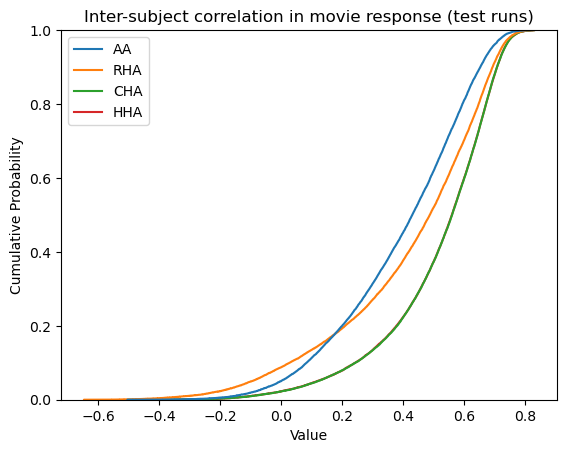

In [91]:
df2 = pd.DataFrame(np.column_stack((isc_conn_AA_zscore, isc_conn_RHA_zscore, isc_conn_CHA_zscore, isc_conn_HHA_zscore)),
                 columns=["AA", "RHA", "CHA", "HHA"])  
# Plot all ECDFs with automatic legend
sns.ecdfplot(data=df2)
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("Inter-subject correlation in movie response (test runs)")
plt.show()

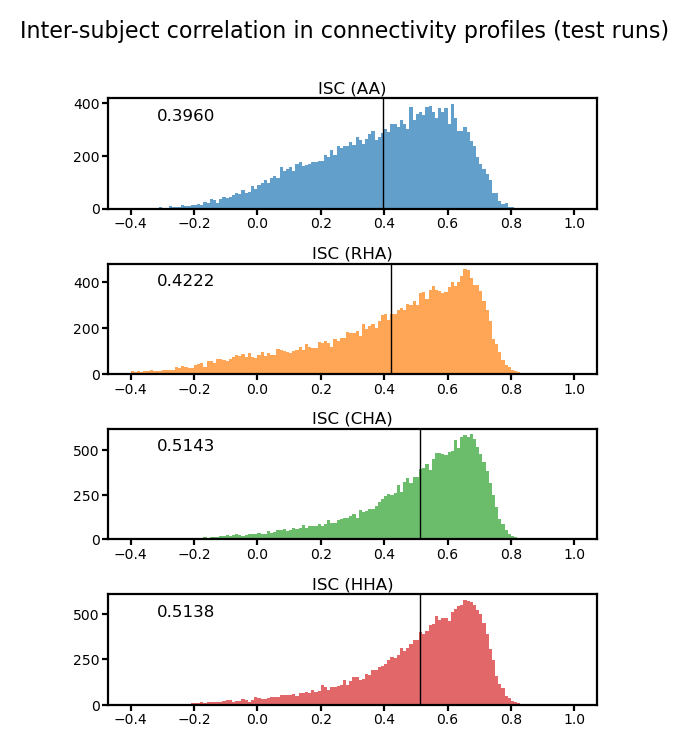

In [92]:
fig, axs = plt.subplots(4, 1, figsize=(8/2.54, 10/2.54), dpi=200)

# Get Seaborn's default blue color (same as ecdfplot)
current_palette = sns.color_palette()

for i, (ax, isc) in enumerate(zip(axs, df2.values.T)):
    # Histogram with Seaborn's default ECDF color
    ax.hist(isc, bins=np.linspace(-0.4, 1.0, 141), color=current_palette[i], alpha=0.7)
    
    # Mean line and annotations
    ax.axvline(isc.mean(), color='k', lw=0.5)
    ax.tick_params('both', size=2, pad=1, labelsize=5)
    
    # Title and mean value annotation
    title = ['ISC (AA)', 'ISC (RHA)', 'ISC (CHA)', 'ISC (HHA)'][i]
    ax.set_title(title, size=6, pad=2)
    ax.annotate(f'{isc.mean():.4f}', (0.1, 0.8), xycoords='axes fraction', size=6)

# Adjust layout and add overall title
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Inter-subject correlation in connectivity profiles (test runs)", fontsize=8)  # Reduced fontsize for tight layout
plt.show()
